# Sentiment Analysis

In [1]:
!pip install datasets

     |████████████████████████████████| 510 kB 3.6 MB/s            
     |████████████████████████████████| 133 kB 43.9 MB/s            
     |████████████████████████████████| 170 kB 80.3 MB/s            
     |████████████████████████████████| 38.3 MB 88.6 MB/s            
     |████████████████████████████████| 388 kB 73.6 MB/s            
     |████████████████████████████████| 193 kB 71.3 MB/s            
     |████████████████████████████████| 116 kB 92.4 MB/s            
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.11.1
    Uninstalling fsspec-2021.11.1:
      Successfully uninstalled fsspec-2021.11.1
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4


In [2]:
!pip install transformers

     |████████████████████████████████| 8.8 MB 3.8 MB/s            
     |████████████████████████████████| 1.2 MB 31.6 MB/s            
     |████████████████████████████████| 773 kB 89.0 MB/s            
     |████████████████████████████████| 3.6 MB 81.1 MB/s            


## Loading Classifier

In [ ]:
import torch
from transformers import pipeline
import pandas as pd
import torch
import datasets
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import ast

def get_model(model_name):
    if torch.cuda.is_available():
        print('Using GPU...')
        classifier = pipeline("text-classification", model=model_name, device=0)
    else:
        print('Using CPU...')
        classifier = pipeline("text-classification", model=model_name, device=-1)
    return classifier

def save_labels(df, output, filename, threshold, col_name):
    final_labels = []
    for labels in output:
        if labels[0]['score'] < threshold:
            final_labels.append('neutral')
        else:
            final_labels.append(labels[0]['label'].lower())
    df[col_name] = final_labels

    df.to_csv(filename, index=False)

In [ ]:
classifier = get_model("zhayunduo/roberta-base-stocktwits-finetuned")

In [16]:
classifier("NVDA holding gem_stone chart_increasing")

[{'label': 'Positive', 'score': 0.9985865354537964}]

In [17]:
classifier = get_model("ProsusAI/Finbert")

Using GPU...


In [18]:
classifier("NVDA shoots through the horizontal resistance of 13.11 and next resistance shall be 13.78")

[{'label': 'neutral', 'score': 0.9257917404174805}]

## Analyzing News Headlines

In [68]:
## Load model
classifier = get_model("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Using GPU...


In [67]:
## Loading csv
news_df = pd.read_csv('meta_news_headlines.csv')

In [69]:
## Getting sentiments
news_output = classifier(news_df["title"].tolist(), top_k=None)

In [73]:
## Save news output
pd.DataFrame(news_output).to_csv("meta_news_output.csv", index=False)

In [74]:
## Get raw output of news sentiment analysis
def get_news_sentiment():
    news_output_df = pd.read_csv("meta_news_output.csv", header=None, skiprows=1)
    news_output_df = news_output_df.applymap(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    news_output = news_output_df.to_dict(orient='records')
    output = []
    for trip in news_output:
        first_dict = trip[0]
        second_dict = trip[1]
        third_dict = trip[2]
        output.append([first_dict, second_dict, third_dict])
    return output

In [75]:
## Saving to csv
news_output = get_news_sentiment()
save_labels(news_df, news_output, "meta_news_sentiment.csv", threshold=0, col_name="label")

## Analyzing StockTwits

In [37]:
## Load model
classifier = get_model("zhayunduo/roberta-base-stocktwits-finetuned")

Using GPU...


In [61]:
## Loading csv
stocktwits_df = pd.read_csv('meta_stocktwits_final.csv')
stocktwits_dataset = Dataset.from_pandas(stocktwits_df)

In [63]:
## Getting sentiments
output_file = "meta_stocktwits_output.csv"

try:
    saved_data = pd.read_csv(output_file)
    num_saved = len(saved_data)
    print(f"{num_saved} data points already saved. Resuming classification...")
except FileNotFoundError:
    num_saved = 0
    print("No existing saved data. Starting classification...")

stocktwits_output = []
for i, out in enumerate(tqdm(classifier(KeyDataset(stocktwits_dataset, "body_prepared")[num_saved:], batch_size=32, top_k=None, truncation=True), total=len(stocktwits_dataset))):
    stocktwits_output.append(out)
    ## save output every 5000 data points
    if (i + 1) % 5000 == 0:
        pd.DataFrame(stocktwits_output).to_csv(output_file, mode='a', index=False, header=(i == 4999))
        stocktwits_output = []
    
## save remaining outputs
if stocktwits_output:
    pd.DataFrame(stocktwits_output).to_csv(output_file, mode='a', index=False, header=False)

359908 data points already saved. Resuming classification...


  0%|          | 0/359908 [00:00<?, ?it/s]

In [65]:
## Get raw output of stocktwits sentiment analysis
def get_stocktwits_sentiment():
    stocktwits_output_df = pd.read_csv("meta_stocktwits_output.csv", header=None, skiprows=1)
    stocktwits_output_df = stocktwits_output_df.applymap(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    stocktwits_output = stocktwits_output_df.to_dict(orient='records')
    output = []
    for pair in stocktwits_output:
        first_dict = pair[0]
        second_dict = pair[1]
        output.append([first_dict, second_dict])
    return output

In [66]:
## Saving to csv
stocktwits_output = get_stocktwits_sentiment()
save_labels(stocktwits_df, stocktwits_output, "meta_stocktwits_sentiment.csv", 0, col_name="raw label")
save_labels(stocktwits_df, stocktwits_output, "meta_stocktwits_sentiment.csv", .75, col_name="thresholded label")

## Testing Sentiment Accuracy for StockTwits

In [9]:
user_labeled = pd.read_csv('nvda_stocktwits_final.csv')
roberta_labeled = pd.read_csv('nvda_stocktwits_sentiment.csv', lineterminator='\n')

In [38]:
def sample_labeled(roberta_labeled, save_csv=False):
    sampled_roberta = roberta_labeled[roberta_labeled['sentiment'].isin(['negative', 'positive'])]
    sampled_roberta = sampled_roberta.sample(n=10000)
    if save_csv:
        sampled_roberta.to_csv("nvda_sampled_roberta_labeled.csv", index=False)
    return sampled_roberta

In [39]:
classifier = get_model("zhayunduo/roberta-base-stocktwits-finetuned")
stocktwits_df = pd.read_csv('nvda_neutral_samples.csv')
stocktwits_dataset = Dataset.from_pandas(stocktwits_df)
stocktwits_output = []
for out in tqdm(classifier(KeyDataset(stocktwits_dataset, "body_prepared"), batch_size=32, top_k=None, truncation=True), total=len(stocktwits_dataset)):
    stocktwits_output.append(out)

Using GPU...


  0%|          | 0/20 [00:00<?, ?it/s]

In [65]:
## Get accuracies of unlabeled data with thresholding
stocktwits_df = pd.read_csv('nvda_neutral_samples.csv')
thresholds = [0, .6, .75, .8, .9]
for threshold in thresholds:
    save_labels(stocktwits_df, stocktwits_output, f"nvda_stocktwits_sentiment_neutral_sample.csv", threshold)
    sample_roberta = pd.read_csv(f"nvda_stocktwits_sentiment_neutral_sample.csv", lineterminator='\n')
    # sampled_roberta = sample_labeled(roberta_labeled)
    accuracy = (sample_roberta["sentiment"] == sample_roberta["label"]).sum() / len(sample_roberta)
    print(f"Accuracy with threshold = {threshold}: {accuracy}")

Accuracy with threshold = 0: 0.0
Accuracy with threshold = 0.6: 0.05
Accuracy with threshold = 0.75: 0.2
Accuracy with threshold = 0.8: 0.2
Accuracy with threshold = 0.9: 0.3


In [67]:
## Get accuracies of labeled data with thresholding
stocktwits_df = pd.read_csv('nvda_stocktwits_final.csv')
output = get_stocktwits_sentiment()
thresholds = [0, .6, .75, .8, .9]
for threshold in thresholds:
    save_labels(stocktwits_df, output, f"nvda_stocktwits_sentiment.csv", threshold)
    roberta_labeled = pd.read_csv(f"nvda_stocktwits_sentiment.csv", lineterminator='\n')
    sampled_roberta = sample_labeled(roberta_labeled)
    accuracy = (sampled_roberta["sentiment"] == sampled_roberta["label"]).sum() / len(sampled_roberta)
    print(f"Accuracy with threshold = {threshold}: {accuracy}")

Accuracy with threshold = 0: 0.9075
Accuracy with threshold = 0.6: 0.9043
Accuracy with threshold = 0.75: 0.863
Accuracy with threshold = 0.8: 0.8445
Accuracy with threshold = 0.9: 0.8026


In [80]:
## Add columns for thresholding and non-thresholding of all data (threshold = .75)
output = get_stocktwits_sentiment()

threshold = 0
stocktwits_df = pd.read_csv('nvda_stocktwits_final.csv')
save_labels(stocktwits_df, output, f"nvda_stocktwits_sentiment.csv", threshold, "raw label")
roberta_labeled = pd.read_csv(f"nvda_stocktwits_sentiment.csv", lineterminator='\n')
accuracy = (roberta_labeled["sentiment"] == roberta_labeled["raw label"]).sum() / len(roberta_labeled)
print(f"Accuracy with threshold = {threshold}: {accuracy}")

threshold = .75
stocktwits_df = pd.read_csv(f"nvda_stocktwits_sentiment.csv", lineterminator='\n')
save_labels(stocktwits_df, output, f"nvda_stocktwits_sentiment.csv", threshold, "thresholded label")
roberta_labeled = pd.read_csv(f"nvda_stocktwits_sentiment.csv", lineterminator='\n')
accuracy = (roberta_labeled["sentiment"] == roberta_labeled["thresholded label"]).sum() / len(roberta_labeled)
print(f"Accuracy with threshold = {threshold}: {accuracy}")

Accuracy with threshold = 0: 0.37591089063149946
Accuracy with threshold = 0.75: 0.41151629375142296


In [10]:
def compute_accuracy(actual_df, predicted_df):
    correct_predictions = (actual_df['label'] == predicted_df['label']).sum()
    total_samples = len(actual_df)
    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
finbert = get_model("ProsusAI/Finbert")

Using GPU...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
# testing finbert
user_labeled = []
sampled_user_labeled = pd.read_csv('nvda_sampled_user_labeled.csv')
sampled_user_labeled_dataset = Dataset.from_pandas(sampled_user_labeled)
for out in tqdm(finbert(KeyDataset(sampled_user_labeled_dataset, "text"), batch_size=32, top_k=None, truncation=True), total=len(sampled_user_labeled_dataset)):
    user_labeled.append(out)
save_labels(sampled_user_labeled, user_labeled, "nvda_sampled_stocktwits_sentiment.csv")

  0%|          | 0/10000 [00:00<?, ?it/s]

[{'label': 'neutral', 'score': 0.9510737061500549}, {'label': 'negative', 'score': 0.029156435281038284}, {'label': 'positive', 'score': 0.01976984180510044}]


In [15]:
actual = pd.read_csv('nvda_sampled_user_labeled.csv')
predicted = pd.read_csv("nvda_sampled_stocktwits_sentiment.csv")
print(compute_accuracy(actual, predicted))

0.1507


In [14]:
models = [
    {
        "model_name": "ProsusAI/Finbert",
        "short_name": "prosusai_finbert"
    },
    {
        "model_name": "cardiffnlp/twitter-roberta-base-sentiment-latest",
        "short_name": "twitter-roberta"
    },
    {
        "model_name": "zhayunduo/roberta-base-stocktwits-finetuned", 
        "short_name": "roberta-stocktwits"
    },
    {
        "model_name": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
        "short_name": "distilroberta-financial-news"
    },
]

def make_predictions(model, src, dst):
    user_labeled = []
    sampled_user_labeled = pd.read_csv(src)
    sampled_user_labeled_dataset = Dataset.from_pandas(sampled_user_labeled)
    for out in tqdm(model(KeyDataset(sampled_user_labeled_dataset, "text"), batch_size=32, top_k=None, truncation=True), total=len(sampled_user_labeled_dataset)):
        user_labeled.append(out)
    save_labels(sampled_user_labeled, user_labeled, dst)

    
def calc_accuracies(models):
    accuracies = []
    categories = []
    for model_info in models:
        model = get_model(model_info["model_name"])
        print(f"Starting {model_info['short_name']}...")
        make_predictions(model, 'nvda_sampled_user_labeled.csv', f"nvda_{model_info['short_name']}_sentiment.csv")
        actual = pd.read_csv('nvda_sampled_user_labeled.csv')
        predicted = pd.read_csv(f"nvda_{model_info['short_name']}_sentiment.csv")
        acc = compute_accuracy(actual, predicted)
        accuracies.append(acc)
        categories.append(model_info['short_name'])
        print(f"{model_info['short_name']} acc: {acc}")
        del model
        torch.cuda.empty_cache()
    plt.bar(categories, accuracies)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Bar Chart")
    plt.tight_layout()
    plt.show()    
        

In [ ]:
calc_accuracies(models)

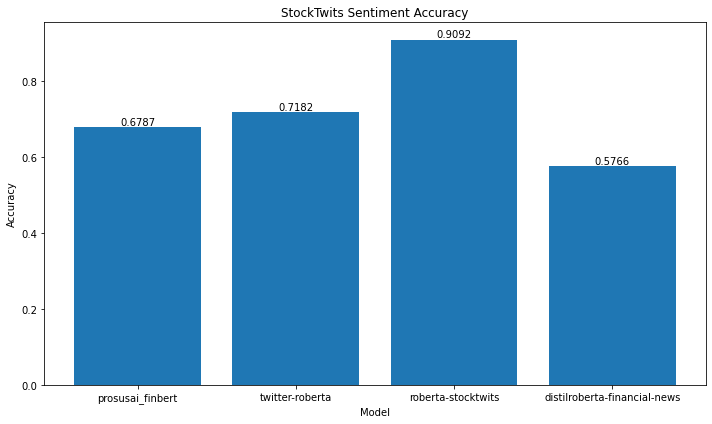

In [19]:
accuracies = [0.6787, 0.7182, 0.9092, 0.5766]
categories = ["prosusai_finbert", "twitter-roberta", "roberta-stocktwits", "distilroberta-financial-news"]
plt.figure(figsize=(10, 6)) 
bars = plt.bar(categories, accuracies)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.4f}', ha='center', va='bottom')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("StockTwits Sentiment Accuracy")
plt.tight_layout()
plt.savefig("stocktwits-barchart.png")
plt.show() 